### SCM

In [1]:
import data_gen as dg
import numpy as np
import random
from numpy.linalg import inv
import causaldag as cd
import visualisation as viz

Create random DAG with p nodes

In [2]:
np.random.seed(13)
random.seed(13)
p = 100
exp_nbrs = 2
d = dg.randomgraph(p, exp_nbrs)
I = np.identity(p)

Randomly assign edge weights, specify the mean and variance of each variable

In [3]:
G = cd.rand.rand_weights(d,dg.unif_close_to_zero)
G._means = np.zeros(p)
G._variances = np.ones(p)

Corresponding SCM parameters (observational)

In [4]:
B_dgp = np.transpose(G.to_amat())
A_dgp = inv(I-B_dgp)
mu_dgp = np.zeros(p).reshape((p,1))
Sigma_dgp = I
theta_dgp = [mu_dgp,B_dgp,Sigma_dgp]

### Interventions

Generate and save the target mean and the true intervention

In [13]:
h_true = np.random.randint(2, size=(p,1))
mu_target = np.matmul(A_dgp,mu_dgp+h_true)
np.savetxt("./data/A_dgp.txt", A_dgp)
np.savetxt("./data/mu_dgp.txt", mu_dgp)
np.savetxt("./data/mu_target.txt", mu_target)

In [17]:
A_dgp[1]

array([ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.24981064,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.36081345,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.27296674,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

Define the reward function

In [18]:
def reward(h, A_dgp, mu_dgp, mu_target):
    h = h.reshape((-1,1))
    res = (mu_target-np.matmul(A_dgp,mu_dgp+h)).reshape(-1)
    return -np.inner(res,res)

Generate binary interventions and their true reward

In [19]:
num = 5000
H = np.random.randint(2, size=(num, p))
R = []
for i in range(num):
    R.append(reward(H[i], A_dgp, mu_dgp, mu_target))

In [20]:
print("max reward: ", reward(h_true, A_dgp, mu_dgp, mu_target))
print("current best: ", max(R))

max reward:  -0.0
current best:  -37.59175651767242


### Features

Save the (input, output) pairs

In [21]:
design = []
X = []
Y = []
for i in range(num):
    d = " ".join([str(j) for j in H[i]])
    h = np.matmul(H[i].reshape(-1,1),H[i].reshape(1,-1)).reshape(-1)
    h = " ".join([str(j) for j in h])
    if d not in design:
        design.append("".join([str(j) for j in H[i]]))
        X.append(d+" "+h+" "+"1")
        Y.append(R[i])
        
num = len(design)
with open("./data/X.txt","w") as file:
    for i in range(num):
        file.write(X[i])
        file.write("\n")
        
with open("./data/Y.txt","w") as file:
    for i in range(num):
        file.write(str(Y[i]))
        file.write("\n")
        
with open("./data/design.txt","w") as file:
    for i in range(num):
        file.write(design[i])
        file.write("\n")

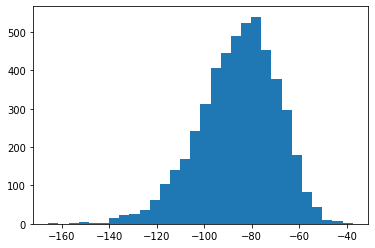

In [22]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(R, bins=30)
plt.show()

In [150]:
R.sort()
np.mean(R[-10:])

-43.53909662052864

### Linear Models

Get the 100 principle componets

- Check if 100 principle component can give a good estimation of the objective value

In [2]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import linear_model
from scipy.stats import spearmanr

In [147]:
X = np.loadtxt("./data/X.txt")
pca = PCA(n_components=100)
pca.fit(X)
X_pca = pca.transform(X)

Generate and test a random linear model

- 100 samples can give a good estimate of the linear model

SpearmanrResult(correlation=0.9826905775156229, pvalue=0.0)


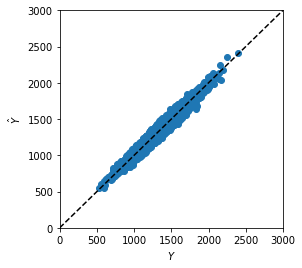

In [148]:
theta = np.random.rand(p*p+p+1)
Y = np.matmul(X,theta.reshape(-1,1))

idx = np.random.permutation(5000)[0:100] 
reg = linear_model.LinearRegression()
reg.fit(X_pca[idx,:], Y[idx])
hat_theta = reg.coef_
intercept = reg.intercept_
hat_Y = np.matmul(X_pca, hat_theta.reshape(-1,1))+intercept

fig = plt.figure(figsize=(4,4))
plt.scatter(Y,hat_Y)
plt.xlabel(r'$Y$')
plt.ylabel(r'$\hat{Y}$')
plt.xlim(0,3000)
plt.ylim(0,3000)
plt.plot([0,3000],[0,3000],color='black',linestyle='dashed')

print("{}".format(spearmanr(Y,hat_Y)))

Test the reward function

- 100 samples

SpearmanrResult(correlation=0.4018639837865593, pvalue=1.9456532260156973e-193)


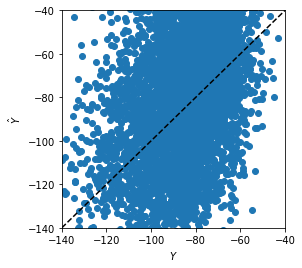

In [120]:
idx = np.random.permutation(5000)[0:100] 
reg = linear_model.Ridge(alpha=1)
reg.fit(X_pca[idx,:], Y[idx])
hat_theta = reg.coef_
intercept = reg.intercept_
hat_Y = np.matmul(X_pca, hat_theta.reshape(-1,1))+intercept

fig = plt.figure(figsize=(4,4))
plt.scatter(Y,hat_Y)
plt.xlabel(r'$Y$')
plt.ylabel(r'$\hat{Y}$')
plt.xlim(-140,-40)
plt.ylim(-140,-40)
plt.plot([-140,-40],[-140,-40],color='black',linestyle='dashed')

print("{}".format(spearmanr(Y,hat_Y)))

- 200 samples

SpearmanrResult(correlation=0.8553607249344289, pvalue=0.0)


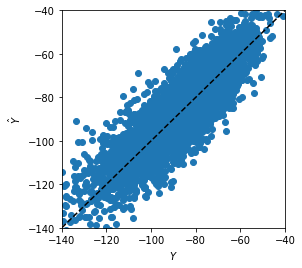

In [121]:
idx = np.random.permutation(5000)[0:200] 
reg = linear_model.Ridge(alpha=1)
reg.fit(X_pca[idx,:], Y[idx])
hat_theta = reg.coef_
intercept = reg.intercept_
hat_Y = np.matmul(X_pca, hat_theta.reshape(-1,1))+intercept

fig = plt.figure(figsize=(4,4))
plt.scatter(Y,hat_Y)
plt.xlabel(r'$Y$')
plt.ylabel(r'$\hat{Y}$')
plt.xlim(-140,-40)
plt.ylim(-140,-40)
plt.plot([-140,-40],[-140,-40],color='black',linestyle='dashed')

print("{}".format(spearmanr(Y,hat_Y)))

- number of samples vs spearman score

Text(0, 0.5, 'spearman score')

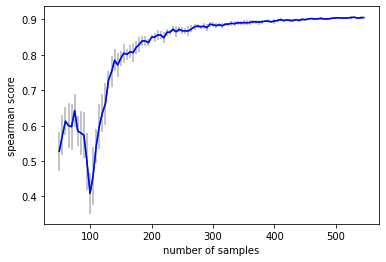

In [110]:
ns = list(range(50, 550, 5))
ss = []
sv = []
for n in ns:
    tmp = []
    for t in range(10):
        idx = np.random.permutation(5000)[0:n] 
        reg = linear_model.Ridge(alpha=1)
        reg.fit(X_pca[idx,:], Y[idx])
        hat_theta = reg.coef_
        intercept = reg.intercept_
        hat_Y = np.matmul(X_pca, hat_theta.reshape(-1,1))+intercept
        tmp.append(spearmanr(Y,hat_Y).correlation)
    ss.append(np.average(tmp))
    sv.append(np.var(tmp)**0.5)
    
plt.plot(ns, ss)
plt.errorbar(ns, ss, yerr = sv,ecolor='0.7',color='b')
plt.xlabel('number of samples')
plt.ylabel('spearman score')

Test on original data

- the original data gives a good estimation

Text(0, 0.5, 'spearman score')

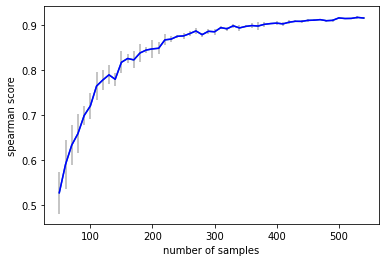

In [114]:
ns = list(range(50, 550, 10))
ss = []
sv = []
for n in ns:
    tmp = []
    for t in range(5):
        idx = np.random.permutation(5000)[0:n] 
        reg = linear_model.Ridge(alpha=1)
        reg.fit(X[idx,:], Y[idx])
        hat_theta = reg.coef_
        intercept = reg.intercept_
        hat_Y = np.matmul(X, hat_theta.reshape(-1,1))+intercept
        tmp.append(spearmanr(Y,hat_Y).correlation)
    ss.append(np.average(tmp))
    sv.append(np.var(tmp)**0.5)
    
plt.plot(ns, ss)
plt.errorbar(ns, ss, yerr = sv,ecolor='0.7',color='b')
plt.xlabel('number of samples')
plt.ylabel('spearman score')

Test on 300 pcs

Text(0, 0.5, 'spearman score')

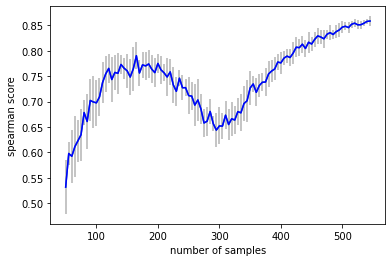

In [123]:
X = np.loadtxt("./data/X.txt")
pca = PCA(n_components=300)
pca.fit(X)
X_pca = pca.transform(X)

ns = list(range(50, 550, 5))
ss = []
sv = []
for n in ns:
    tmp = []
    for t in range(10):
        idx = np.random.permutation(5000)[0:n] 
        reg = linear_model.Ridge(alpha=1)
        reg.fit(X_pca[idx,:], Y[idx])
        hat_theta = reg.coef_
        intercept = reg.intercept_
        hat_Y = np.matmul(X_pca, hat_theta.reshape(-1,1))+intercept
        tmp.append(spearmanr(Y,hat_Y).correlation)
    ss.append(np.average(tmp))
    sv.append(np.var(tmp)**0.5)
    
plt.plot(ns, ss)
plt.errorbar(ns, ss, yerr = sv,ecolor='0.7',color='b')
plt.xlabel('number of samples')
plt.ylabel('spearman score')

Test on 200 pcs

Text(0, 0.5, 'spearman score')

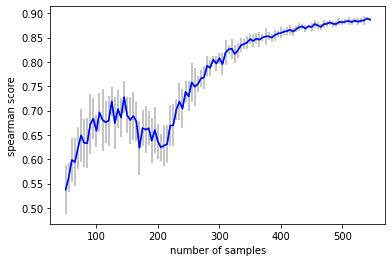

In [124]:
X = np.loadtxt("./data/X.txt")
pca = PCA(n_components=200)
pca.fit(X)
X_pca = pca.transform(X)

ns = list(range(50, 550, 5))
ss = []
sv = []
for n in ns:
    tmp = []
    for t in range(10):
        idx = np.random.permutation(5000)[0:n] 
        reg = linear_model.Ridge(alpha=1)
        reg.fit(X_pca[idx,:], Y[idx])
        hat_theta = reg.coef_
        intercept = reg.intercept_
        hat_Y = np.matmul(X_pca, hat_theta.reshape(-1,1))+intercept
        tmp.append(spearmanr(Y,hat_Y).correlation)
    ss.append(np.average(tmp))
    sv.append(np.var(tmp)**0.5)
    
plt.plot(ns, ss)
plt.errorbar(ns, ss, yerr = sv,ecolor='0.7',color='b')
plt.xlabel('number of samples')
plt.ylabel('spearman score')

Test on 500 pcs

Text(0, 0.5, 'spearman score')

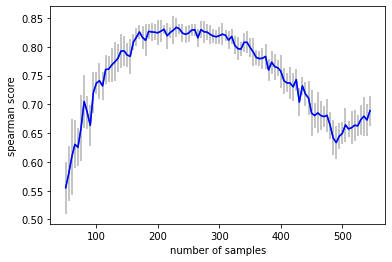

In [125]:
X = np.loadtxt("./data/X.txt")
pca = PCA(n_components=500)
pca.fit(X)
X_pca = pca.transform(X)

ns = list(range(50, 550, 5))
ss = []
sv = []
for n in ns:
    tmp = []
    for t in range(10):
        idx = np.random.permutation(5000)[0:n] 
        reg = linear_model.Ridge(alpha=1)
        reg.fit(X_pca[idx,:], Y[idx])
        hat_theta = reg.coef_
        intercept = reg.intercept_
        hat_Y = np.matmul(X_pca, hat_theta.reshape(-1,1))+intercept
        tmp.append(spearmanr(Y,hat_Y).correlation)
    ss.append(np.average(tmp))
    sv.append(np.var(tmp)**0.5)
    
plt.plot(ns, ss)
plt.errorbar(ns, ss, yerr = sv,ecolor='0.7',color='b')
plt.xlabel('number of samples')
plt.ylabel('spearman score')

Are 200 samples and 100 pcs enough in general?

In [127]:
X = np.loadtxt("./data/X.txt")
pca = PCA(n_components=100)
pca.fit(X)
X_pca = pca.transform(X)

idx = np.random.permutation(5000)[0:200] 
reg = linear_model.Ridge(alpha=1)
reg.fit(X_pca[idx,:], Y[idx])
hat_theta = reg.coef_
intercept = reg.intercept_

In [131]:
num = 10000
H_new = np.random.randint(2, size=(num, p))
R_new = []
for i in range(num):
    R_new.append(reward(H_new[i], A_dgp, mu_dgp, mu_target))
X_new = []
for i in range(num):
    d = [j for j in H_new[i]]
    h = [j for j in np.matmul(H_new[i].reshape(-1,1),H_new[i].reshape(1,-1)).reshape(-1)]
    X_new.append(d+h+[1])

SpearmanrResult(correlation=0.8566076321860764, pvalue=0.0)


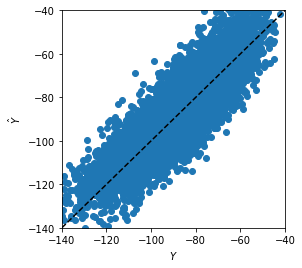

In [134]:
X_new_pca = pca.transform(X_new)
hat_R_new = np.matmul(np.array(X_new_pca), hat_theta.reshape(-1,1))+intercept
fig = plt.figure(figsize=(4,4))
plt.scatter(R_new,hat_R_new)
plt.xlabel(r'$Y$')
plt.ylabel(r'$\hat{Y}$')
plt.xlim(-140,-40)
plt.ylim(-140,-40)
plt.plot([-140,-40],[-140,-40],color='black',linestyle='dashed')

print("{}".format(spearmanr(R_new,hat_R_new)))

### Two Approaches

- reducing the feasible set $\{0,1\}^p$ to a subset of 5000 interventions.
- use 100 principal components for estimation.

Sequential method:
- 4 time steps
- each time, pick a batch of 200 interventions

Non-sequential method:
- use batch size $\in \{200,400,600\}$

Tuning the confidence elliposid radius:

c=1
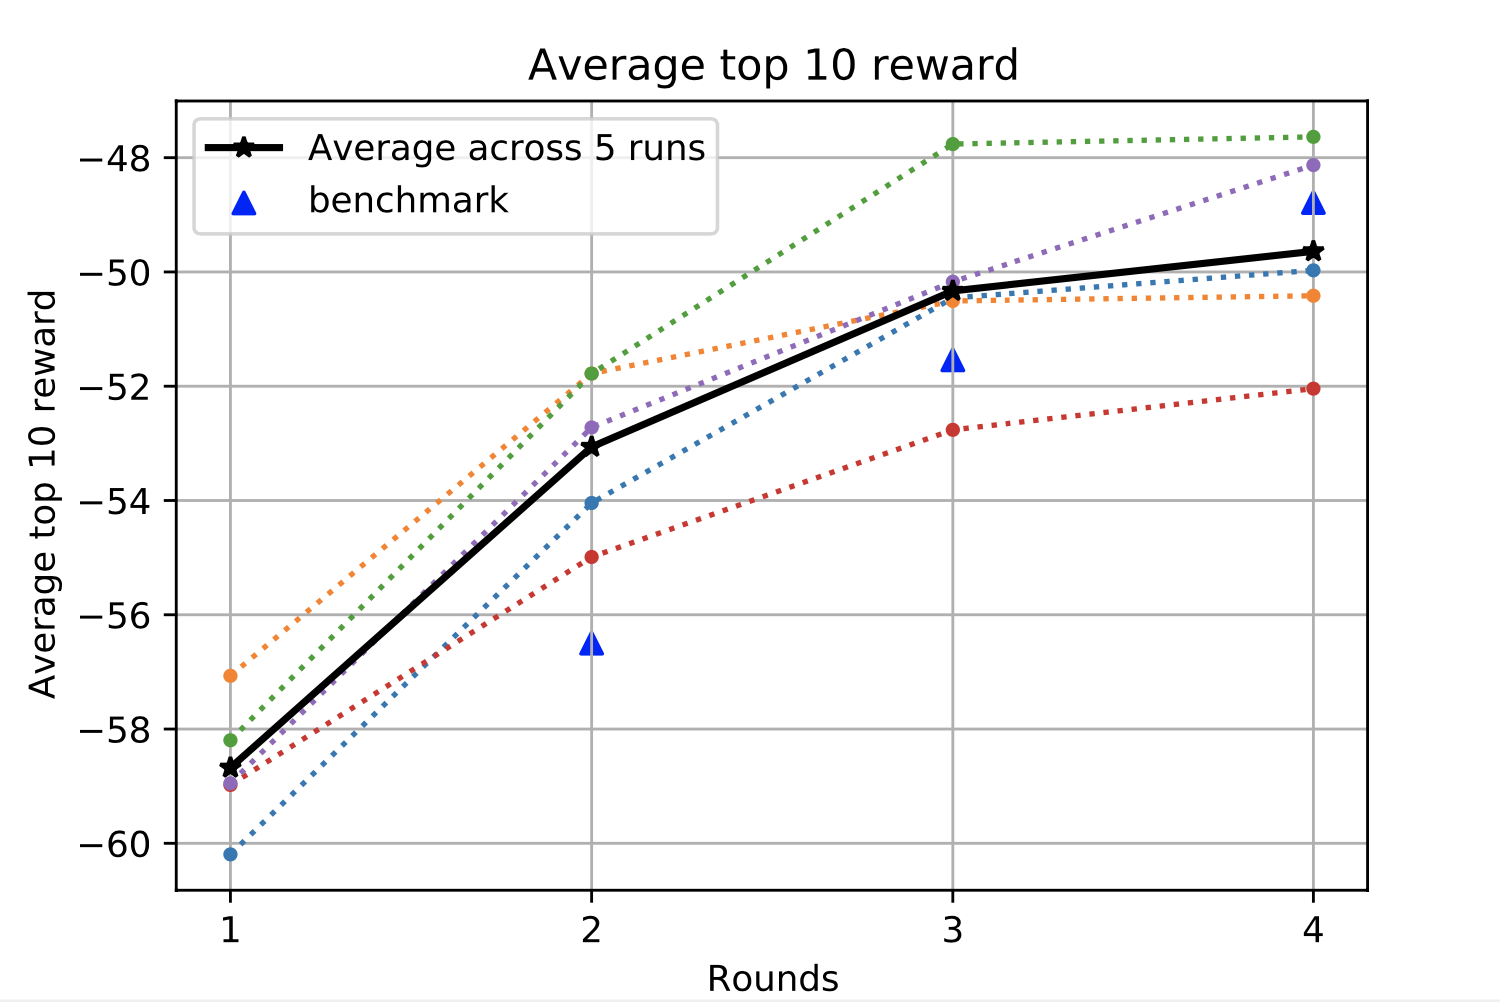

c=2
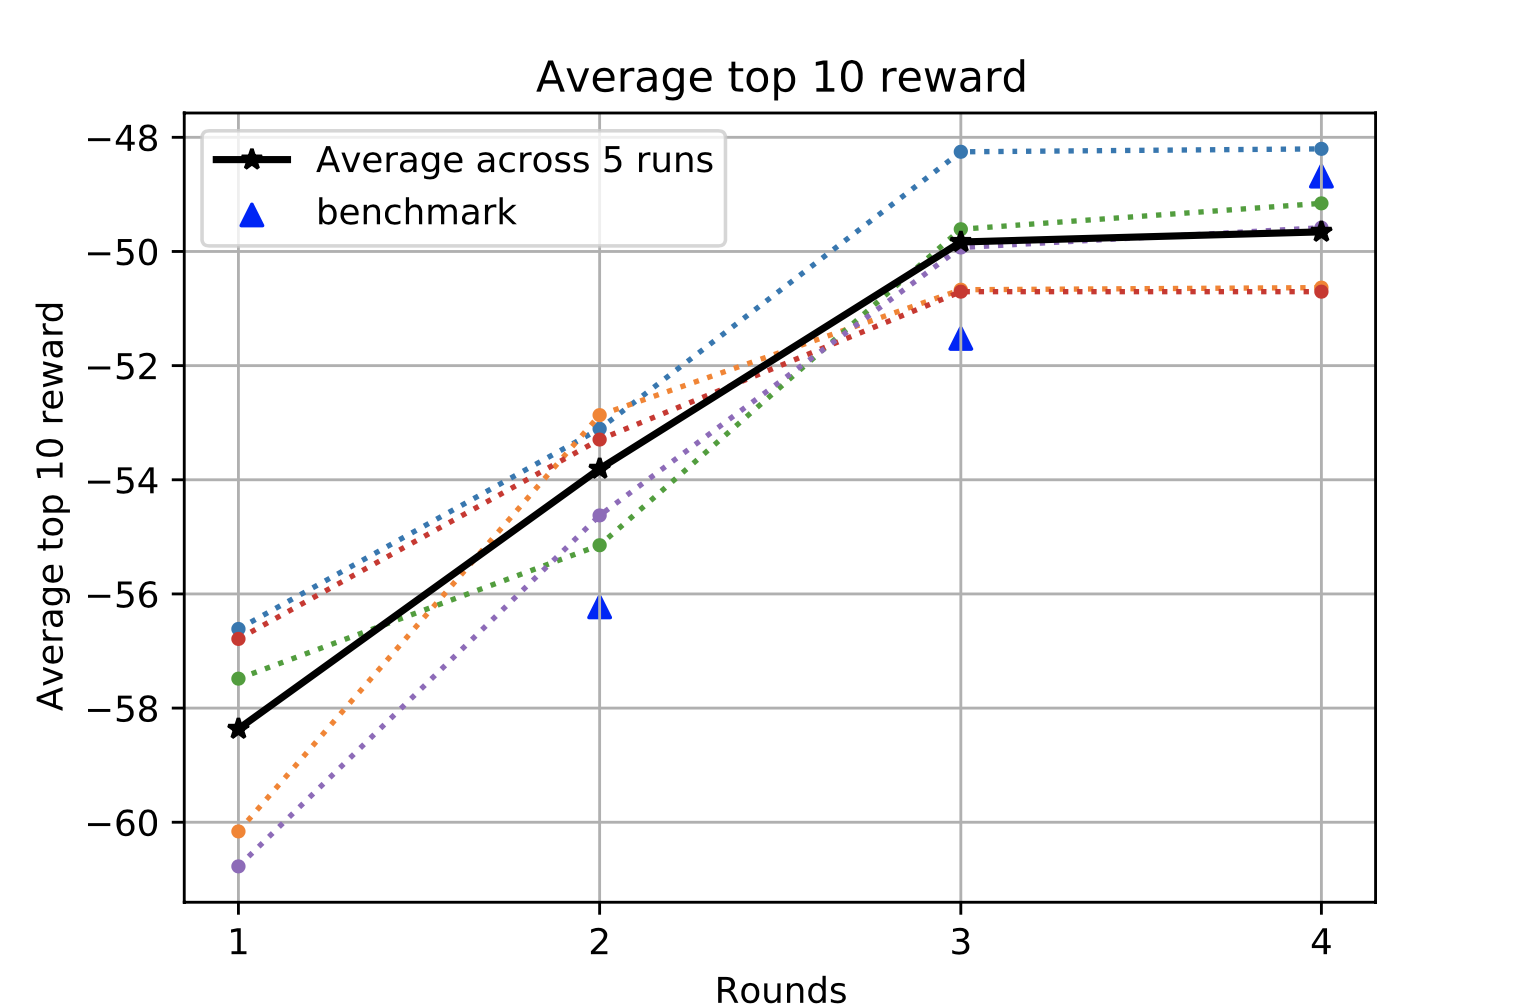

c=4
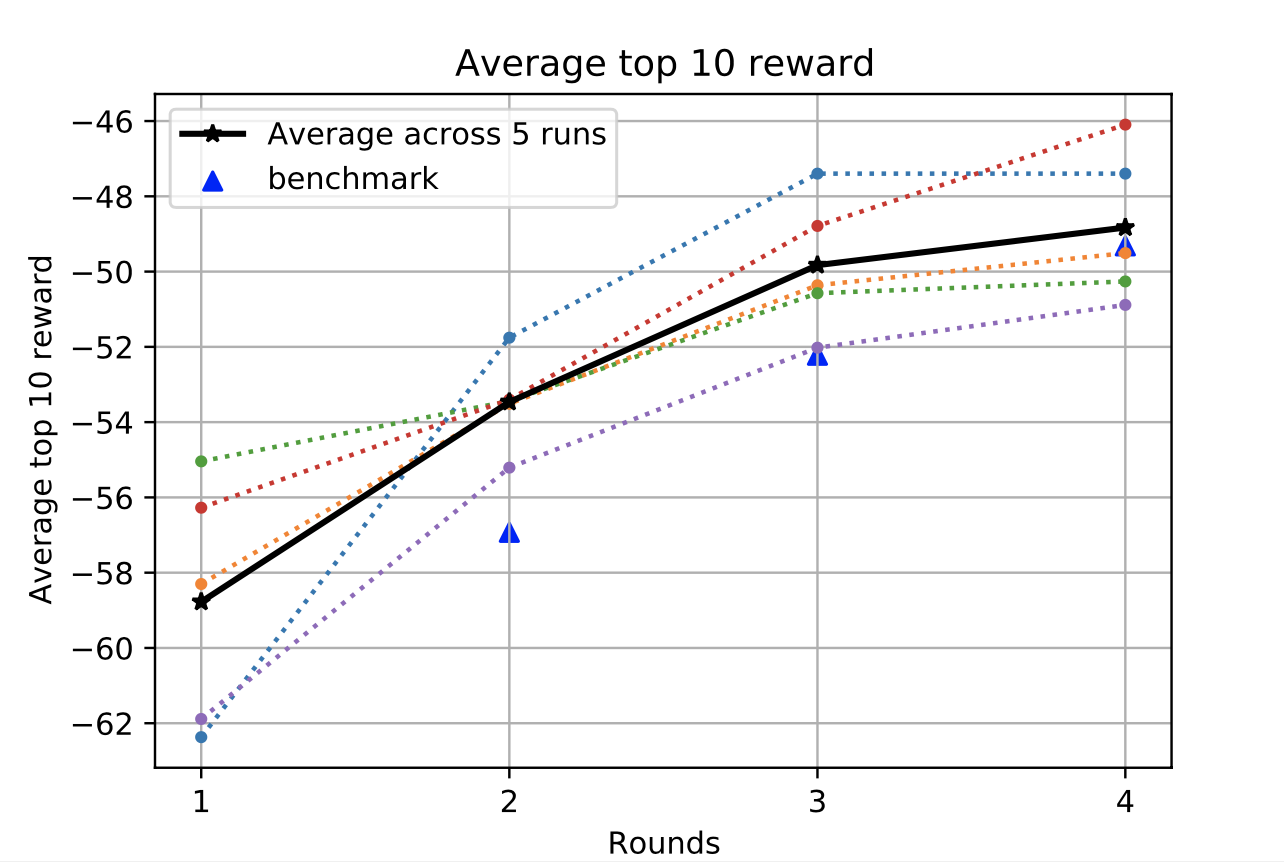

c=8
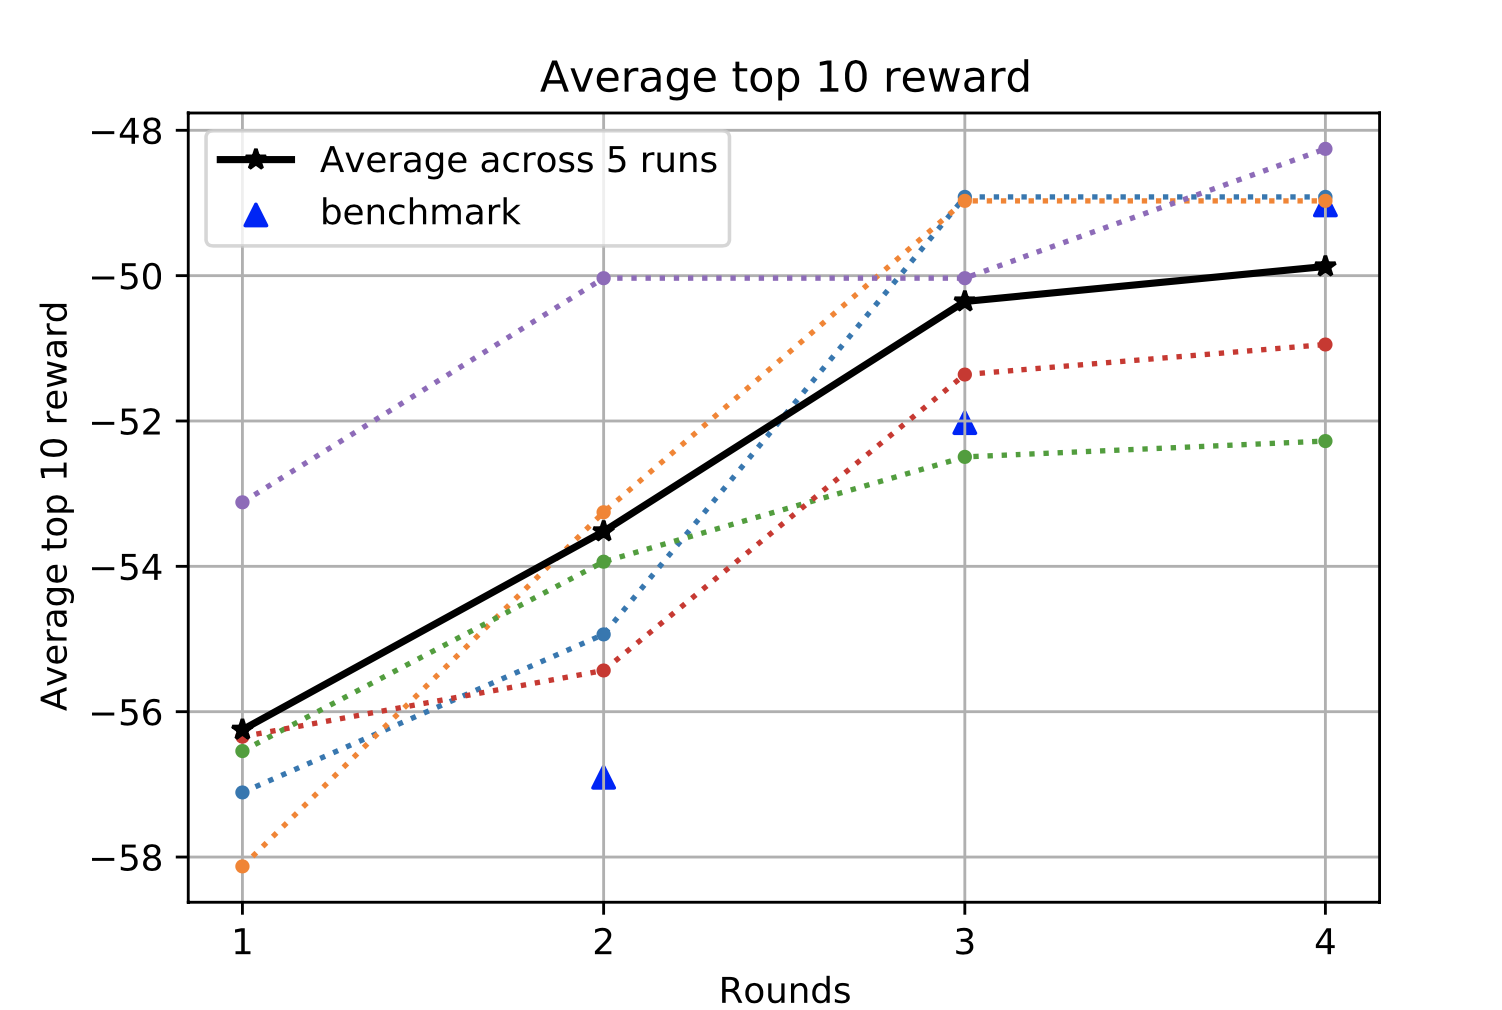

In [4]:
intervention = np.loadtxt('./data/intervention.txt')
reward = np.loadtxt('./data/reward.txt')

In [5]:
from sklearn.preprocessing import PolynomialFeatures


def get_feature(intervention):
    feature_func = PolynomialFeatures(degree=2, interaction_only=True)
    if len(intervention.shape) == 1:
        intervention = intervention.reshape(1, -1)
    feature = feature_func.fit_transform(intervention)
    return feature

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

feature = get_feature(intervention)
transformer = None
if True:
    transformer = Pipeline(steps=[('pca', PCA(n_components=100)), ('standardizer', StandardScaler())])
    feature = transformer.fit_transform(feature)

In [11]:
idx = np.random.choice(range(len(intervention)), 200, replace=False)
x = feature[idx]
y = reward[idx]

In [37]:
reg = linear_model.Ridge(alpha=1,fit_intercept=False)
reg.fit(x, y-np.mean(y))
hat_theta = reg.coef_
intercept = reg.intercept_
hat_r = np.matmul(feature, hat_theta.reshape(-1,1))+intercept
print(spearmanr(reward,hat_r))

SpearmanrResult(correlation=0.8510747149069884, pvalue=0.0)


In [17]:
_, p = x.shape
v = np.dot(x.T, x) + 1 * np.eye(p)
iv = inv(v)
theta = np.dot(iv, np.dot(x.T, y))

In [26]:
values = np.dot(feature, theta).reshape(-1,1)
print(spearmanr(reward,values))

SpearmanrResult(correlation=0.15270939874837594, pvalue=1.802584217403579e-27)
